# Exercise 0.1: Python, PyROOT, RooFit, Basics
 >__Created__:  25 June 2018 Harrison B. Prosper, ESHEP 18, Maratea, Italy
 
 
 This notebook gives a basic introduction to __Python__, __PyROOT__, __RooFit__, and __RooStats__. It is an implementation of Glen Cowan's exercise at INFN SOS 2013, Vietri sul Mare, Italy.
 
 ### Python Tips
  * Python uses indentation to create program blocks.
    Semicolons are not needed as in C++. It is therefore convenient to use
    a Python-aware editor, such as __emacs__. This will help
    minimize indentation errors.

  * Python handles pointers for you! Use "." as in

           TMath.Prob

    instead of TMath::Prob

  * There are two basic ways to load program modules into memory, e.g.:

          import os
    and
          from string import replace
          
    Also note
    
          import numpy as np

  * Strings can be initialized either with single or double quotes,
    'ABC' or "ABC". This is useful when "ABC" needs to be embedded within
    a string. Use \ to continue strings across lines: 

            poem = 'You blocks you stones\n'\
                   'You worse than senseless things'

  * *WARNING*: Python uses __dynamic typing__, which means that the type of
    a variable is detemined at runtime by its value. Consequently,
    a variable's type is, well, variable!

    x = 0     x is an integer
    x = 0.0   x is now a float
    x ='0'    x is now a string

    Also (in Python 2.7.X) beware of

    x = 42
    y = x / 84

    The answer will be y = 0 because x is an integer!

  * Insert sys.exit() to stop program at any line. Useful for
    debugging.

In [1]:
import os, sys
import ROOT
# turn off ROOT use of javascript
%jsroot off

Welcome to JupyROOT 6.12/06


### Create a RooStats workspace

In [2]:
# Suppress all messages except those that matter
msgservice = ROOT.RooMsgService.instance()
    
# If a crash occurs, or things look strange,
# comment out next line to find out more information about the problem.
msgservice.setGlobalKillBelow(ROOT.RooFit.FATAL)

# The most convenient way to use RooFit/RooStats is to 
# make a workspace so that we can use its factory method
wspace = ROOT.RooWorkspace('ESHEP')


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



### Create parameters of double-exponential model

In [3]:
# The observable is x and lies in the range [0, 20]
xmin = 0.0 # note this is a float
xmax =20.0 # and so is this

# Use the factory method of the RooWorkspace object, just
# created, to create an object called x that represents the
# observable.
# syntax:
#        <name>[value, min-value, max-value]
#
# We are using Python's ability to write numbers into strings,
# which is modeled on the semantics of C
wspace.factory('x[0,%f,%f]' % (xmin, xmax))

# Set the NUMBER OF BINS,
# either for display purposes
# or for the binned fit.
M = 15 
wspace.var('x').setBins(M)

# Create the parameters of the model (a, b, c)
wspace.factory('a[0.4, 0.0,   1.0]')
wspace.factory('b[3.0, 0.01, 20.0]')
wspace.factory('c[9.0, 0.01, 20.0]')
parameters = ['a', 'b', 'c']

# NUMBER OF PARAMETERS
P = len(parameters)

### Create probability model
The model to be fitted, called *model*, is defined
 by a probability function (in this case, a density function (pdf)) of the form

   $$p(x\, |\, a, b, c) = a \, \exp(-x \, / \, b)\, / \, b + (1 - a) \, \exp(-x\, /v \, c) \, / \, c.$$

The syntax for creating a pdf, here a user-defined pdf using
the RooStats class __RooGenericPdf__, is
```c++
 GenericPdf::<user-defined-name>("<function>", {...})
```
 where we always drop the "Roo" prefix. 
#### Example
```python
  wspace.factory('GenericPdf::model("dbexp(x,a,b,c)", {x,a,b,c})')
```
 
 Note use of braces {..}
 in the above to specify a list of variables
 (modeled in RooFit by the __RooArgList__ class).

 __Tip__: The desired pdf can be coded as a C++
 function (with simple argument types, e.g., double and int arguments) compiled
 using, for example,
```python
  ROOT.gROOT.ProcessLine('.L <function>.cc+')
```
and made known to Python using
```python
  from ROOT import <function>
```
#### Example
```python
  ROOT.gROOT.ProcessLine('.L src/models.cc+')
  from ROOT import dbexp
```
Root 6 uses a real compiler (rather than an interpreter), therefore,
 the syntax of your C++ code must conform to standard C++.

 If you need to make the compiler and linker happy by including
 headers and libraries beyond the default set provided by ROOT,
 first do
```python
   ROOT.gSystem.AddInlcudePath('-I<path1> ...')
   ROOT.gSystem.AddLinkedLibs('-L<libdir> -l<library> ...')
```
 before calling gROOT.ProcessLine.

 Since the probability model is rather simple, we don't really have to use a C++ program! The model
 can be create directly as follows
```python
 wspace.factory('GenericPdf::model'\
                '("a*exp(-x/b)/b + (1-a)*exp(-x/c)/c",'\
                '{x,a,c,c})')
```

In [4]:
ROOT.gROOT.ProcessLine('.L src/models.cc+')
from ROOT import dbexp
wspace.factory('GenericPdf::model("dbexp(x,a,b,c)", {x,a,b,c})'); # use ";" to suppress listing of object

So far, the "model" is known only to the RooFit workspace.
Make the model known to Python also

In [6]:
model = wspace.pdf('model')

### Generate some data from the model

In [7]:
# define the set obs = (x)
wspace.defineSet('obs', 'x')

# make the set obs known to Python
obs  = wspace.set('obs')

# generate data
T = 400 # number of data to generate
data = model.generate(obs, T)

## Perform fit of model to $\underline{unbinned}$ data

In [14]:
swatch = ROOT.TStopwatch()
swatch.Start()

# If more control is needed, you can call RooMinuit
# directly, which is an interface to Minuit.
# Here, we are happy to use the simpler interface "fitTo".
# Remember to save the results of the fit to a results object
results = model.fitTo(data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1))
print "real time: %10.3f s" % swatch.RealTime()

# Let's see what we got
results.Print()

real time:      0.018 s

  RooFitResult: minimized FCN value: 1019.82, estimated distance to minimum: 1.63507e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                     a    3.2208e-01 +/-  1.86e-01
                     b    2.0293e+00 +/-  9.06e-01
                     c    8.4071e+00 +/-  2.81e+00



### Print correlation matrix

In [15]:
print "\tcorrelation matrix"
print "%10s" % "",
for v in parameters:
    print "%10s" % v,
print  # use this to print a newline character
for v1 in parameters:
    print "%-10s" % v1, # first print label and suppress a newline
    for v2 in parameters:
        cor = results.correlation(v1, v2)
        print '%10.3f' % cor,
    print # print a newline character


	correlation matrix
                    a          b          c
a               1.000      0.926      0.924
b               0.926      1.000      0.829
c               0.924      0.829      1.000


### Plot using RooFit
We wish to plot the distribution of the data and
 superimpose the fitted model as a function of the
 observable x.
 This is how RooFit makes plots, which unfortunately it is not as intuitive as it could have been!
  
 In RooFit, one does proceeds as follows:
  * create a frame pertaining to x (which we call xframe)
  * set the frame's attributes, of which there are many
  * tell the data to place a plot of themselves on xframe
  * tell the model to place a plot of itself on xframe
  * tell the model to place its parameters on xframe
  * tell the xframe to draw itself on the active canvas
  
If you have trouble making the plot look exactly as you
 wish it to look, try drawing an empty Root histogram
 first in order to define the plotting area, then Draw
 xframe using the "same" option.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fig_unbinnedFit
Info in <TCanvas::Print>: png file ./fig_unbinnedFit.png has been created


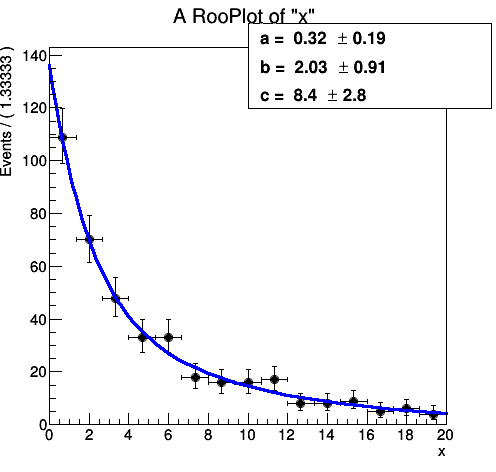

In [20]:
xframe = wspace.var('x').frame()
xframe.SetMinimum(0)     # set minimum y-axis value 
xframe.SetMaximum(100)   # set maximum y-axis value
data.plotOn(xframe)
model.plotOn(xframe)
model.paramOn(xframe)

c1 = ROOT.TCanvas('fig_unbinnedFit', 'fit', 10, 10, 500, 500)
xframe.Draw()
c1.Draw()        # draw inline
c1.SaveAs('.png')

## Perform fit of model to $\underline{binned}$ data

Bin the data using __RooDataHist__.

Note the use of the set __obs__, created above, to tell
RooDataHist the variable(s) with respect to
which the data are to be binned. The number of
bins is obtained from the bin count attribute of "x"
(see above).

In [24]:
hdata = ROOT.RooDataHist('hdata', 'binned data', obs)
hdata.add(data)  # add the data to the RooDataHist and bin them
hdata.Print('verbose')

DataStore hdata (binned data)
  Contains 15 entries
  Observables: 
    1)  x = 5.44215  L(0 - 20) B(15)  "x"
Binned Dataset hdata (binned data)
  Contains 15 bins with a total weight of 400
  Observables:     1)  x = 5.44215  L(0 - 20) B(15)  "x"


Do a multinomial fit to the binned data by
turning off extended likelihood mode. If you
want a multi-Poisson fit, change False to True.
(If interested, ask what all this means!)


  RooFitResult: minimized FCN value: 1025.07, estimated distance to minimum: 0.000130183
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                     a    3.9652e-01 +/-  2.36e-01
                     b    2.5922e+00 +/-  1.05e+00
                     c    9.2677e+00 +/-  4.21e+00



Info in <TCanvas::Print>: png file ./fig_binnedFit.png has been created


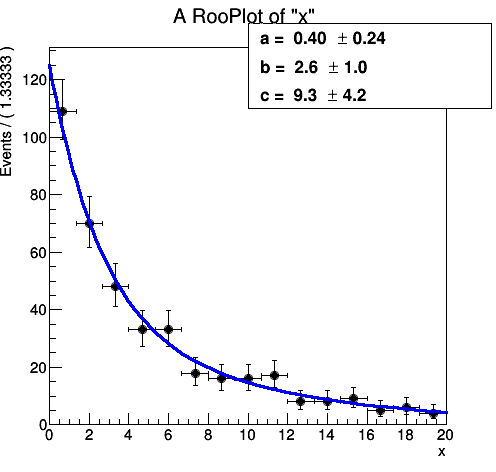

In [27]:
results2 = model.fitTo(hdata,
                       ROOT.RooFit.Save(),
                       ROOT.RooFit.PrintLevel(-1), # silent
                       ROOT.RooFit.Extended(False))
results2.Print()

# Plot results of fit on a different frame
c2 = ROOT.TCanvas('fig_binnedFit', 'fit',
             515, 10, 500, 500)

xframe2 = wspace.var('x').frame()
xframe2.SetMaximum(0)
xframe2.SetMaximum(100)
hdata.plotOn(xframe2)
model.plotOn(xframe2)
model.paramOn(xframe2)
xframe2.Draw()
c2.Draw() # draw inline
c2.SaveAs('.png')

## Do a bit of statistics

We shall compute two __goodness-of-fit__ (gof) measures $X$ and $Y$.

Since we have binned data, we need to create an
 integral to integrate the model over each x-bin
 so that we can compare the expected count in a given
 bin with the observed count in that bin.
 
Our gof measures are
 
  $$X = \sum_{i=1}^M (N_i - n_i)^2 \, / \, n_i,$$
  
where 

$$n_i(\theta) = \int_{bin_i} \, f(x, \, \theta) \, dx ,$$

with $f(x, \, \theta)$, $\theta \equiv a, b, c$, the model to be fitted,
and 

\begin{align*}
        Y & = -2 \ln \, p({\bf N} \, | \, {\bf n}) \, / \, p({\bf N} \, | \, \hat{\bf n}),\\
        &= -2 \ln \, p({\bf N} \, | \, {\bf n}) \, / \, p({\bf N} \, | \, {\bf N}).
\end{align*}

We take $p(N \, | \, n) = N! \prod_{i=1}^M p_i^{N_i} / N_i!$ to be a multinomial likelihood with $p_i = n_i \, / \, \sum_i n_i$; $N = \sum_{i=1}^M  N_i$ is the sum of observed counts
 ${\bf N} = N_1, \cdots, N_M$ and ${\bf n}(\theta) = n_1, \cdots, n_M$ are the (unknown) mean counts,
 which depend on the model parameters $\theta$.

 Let $H_0$ be the hypothesis that $\theta_0$ are the true values
 of the parameters $\theta$. In practice, we approximate $\theta_0$ by $\hat{\theta}$.
 According to Wilks' theorem (1938), the quantity $Y$ has
 (asymptotically) a $\chi^2$ distribution of $M - P - 1$
 degrees of freedom, where
   $M$ is the  number of bins
   and $P$ is the number of fitted parameters. The number of degrees of freedom is reduced by one unit
   because of the constraint $\sum_{i=1}^M N_i = N$. We expect $X$ also to follow the same distribution
   asymptotically.

In order to implement the above, we proceed as follows.
 1. Define the set of variables over which to
 normalize the integral
```python
    normSet = ROOT.RooFit.NormSet(obs) 
```
 2. Define a range variable, call it x-bin, to
 represent the bin boundaries.
```python
    wspace.var('x').setRange('x-bin', xmin, xmax)
```
 3. Create integral
```python
    integral = model.createIntegral(obs, normSet, ROOT.RooFit.Range('x-bin'))
```

Then, 
```
   loop over bins
      compute integral over bin to obtain n_i
      accumulate X and Y with the restriction that N_i > 5
   compute p-value = Pr[X > X_obs]
           p-value = Pr[Y > Y_obs]
```


In [32]:
# 1. define integration variable
normSet = ROOT.RooFit.NormSet(obs)

# 2. define range variable
wspace.var('x').setRange('x-bin', xmin, xmax)

# 3. create integral
integral = model.createIntegral(obs, normSet, ROOT.RooFit.Range('x-bin'))

# Find bin width. Use float function to make sure we have
# a float in the numerator to avoid truncation.
dx = float(xmax-xmin)/M
X  = 0.0
Y  = 0.0
total = 0.0 # to check the total integral (should be = T)
print
print "%5s\t%10s %5s %10s" % ('', 'binlow', "count", "mean")

# range(M) = [0, 1,...M-1]
K = 0 # count number of bins with N_i > 5
for ii in range(M):
    # Get count in bin ii
    # Yes, this is not as tidy as it could have been!
    ibin = hdata.get(ii)   # get object that models iith bin
    Ni   = hdata.weight()  # get bin content (count)

    # Set the bin boundaries in our previously created
    # range object
    x = xmin + ii * dx
    wspace.var('x').setRange('x-bin', x, x+dx)

    # Compute the integral, with respect to x, over current
    # bin and scale result by the total observed count. This
    # gives us the mean count in current bin, evaluated at the
    # best fit values of the parameters.
    ni = T * integral.getVal()
    print "%5d\t%10.3f %5d %10.1f" % (ii+1, x, Ni, ni)

    total += ni
    if Ni < 5: continue

    # Accumulate X and Y
    K += 1
    X += (Ni - ni)**2 / ni
    Y += Ni * ROOT.TMath.Log(ni/Ni) 

# Complete calculation of Y
Y *= -2

# Assuming we are in asymptotia, compute
#    p-value = Int_Y^infinity p(chi^2, ndf) dchi^2
# where p(chi^2, ndf) is the chi2 density of ndf
# degrees of freedom

ndf    = K-P-1  # number of degrees of freedom

if ndf > 0:
    pvalueX = ROOT.TMath.Prob(X, ndf)
    pvalueY = ROOT.TMath.Prob(Y, ndf)
else:
    pvalueX = 1.0
    pvalueY = 1.0
print "="*80
print "Int p(x|xi) dx =%6.1f\n" % total

print "ChiSq/ndf = %6.1f/%d (using X)" % (X, ndf)
print "p-value   = %9.4f\n" % pvalueX

print "ChiSq/ndf = %6.1f/%d (using Y)" % (Y, ndf)
print "p-value   = %9.4f" % pvalueY


     	    binlow count       mean
    1	     0.000   109      103.4
    2	     1.333    70       71.1
    3	     2.667    48       50.6
    4	     4.000    33       37.2
    5	     5.333    33       28.3
    6	     6.667    18       22.2
    7	     8.000    16       17.8
    8	     9.333    16       14.6
    9	    10.667    17       12.1
   10	    12.000     8       10.2
   11	    13.333     8        8.7
   12	    14.667     9        7.4
   13	    16.000     5        6.3
   14	    17.333     6        5.4
   15	    18.667     4        4.7
Int p(x|xi) dx = 400.0

ChiSq/ndf =    6.0/10 (using X)
p-value   =    0.8153

ChiSq/ndf =    7.2/10 (using Y)
p-value   =    0.7033
